# Aave Rewards Program Impact Analysis

# Table of Contents
* [Introduction](#intro)
* [Merit Background](#background)
* [Result Preview](#preview)
* [Methodology](#method)
    * [Metric](#metric)
    * [Synthetic Differences in Differences](#synth)
* [Results](#result)
    * [Estimation](#estimate)
    * [Hypothesis testing](#inf)
    * [Identifying Assumptions](#assume)
* [References](#ref)

## Introduction <a class="anchor" id="intro"></a>
Aave is the largest onchain decentralized lending and borrowing platform of cryptocurrencies. On January 30, 2024, the Aave community announced a rewards program called Merit, which aims to expand its user base and market dominance on the Ethereum blockchain. The program rewards users who borrow wrapped ETH (WETH) and GHO (Aave's own stablecoin). This project focuses on Merit's impact on WETH, and aims to answer the question: did Merit increase amount of WETH borrowed on Aave on the Ethereum blockchain? I apply [synthetic difference-in-differences](https://www.nber.org/system/files/working_papers/w25532/w25532.pdf), a causal inference method, to estimate the causal relationship between Merit and WETH borrowed from January 30, 2024 to April 30, 2024.  

## Aave and Merit Background <a class="anchor" id="background"></a>
Aave is an overcollateralized lending and borrowing platform. In order to borrow, a user must first supply collateral. For example, in order to borrow from the WETH pool, a user can supply USDC (or any other cryptocurrencies accepted by Aave) to the USDC pool. The interest rate paid on the WETH debt depends on the percentage of the WETH pool that has been borrowed. The higher the percentage, the higher the interest rate. See the [Aave documentation](https://docs.aave.com/hub) for more details. 

[Announced](https://governance.aave.com/t/temp-check-merit-a-new-aave-alignment-user-reward-system/16456) on Jan 30, 2024, the Merit program [allocates](https://snapshot.org/#/aave.eth/proposal/0xc80da83fadfe4f8a4c56e1643895cb7e9b1af1d9dcd374f1b41ded5c95b42f68) $2.1M in WETH and $2.9M in GHO for a 90-day duration to borrowers of these two assets, "focusing on direct Aave protocol engagement and promoting diversified staking strategies". In addition to the base rewards for borrowing, the program provides extra rewards (called Merit boosters) for specific behaviors, including: moving positions to Aave from completing platforms, usage of the AAVE token as collateteral, holding AAVE token for more than 100 days in the past year, and etc. The program also "punishes" a specific behavior, that is, the users of Morpho Optimizers cannot receive any rewards. The rewards were distributed 3 times over 90 days, on March 19, April 9, and April 30, 2024. More info on the encouraged and discouraged behaviors can be found [here](https://snapshot.org/#/aave.eth/proposal/0xc80da83fadfe4f8a4c56e1643895cb7e9b1af1d9dcd374f1b41ded5c95b42f68). Lastly, to prevent users from gaming the program, the details of how rewards would be calculated were not disclosed.

The purpose of this project is three fold:
1. Incentive programs have become commonplace in the crypto space, for a range of purposes from bootstrapping liquidity, encouraging community participation, to attracting users. The effectiveness of programs tend to be determined by comparing before and after outcomes. However, given the rapidly changing technological landscape and market dynamics of the industry, before-vs-after comparisons do not account for the confounding events occurring during the same time periods. This project aims to demonstrate a more statistically rigorous method, synthetic difference-in-differences, to evaluate causal, not correlational, impact. This is only one out of many causal inference methods, and the selection of the most suitable method depends the question one is trying to answer, as well as the context surrounding the question. 
2. To answer a causal question in a new field. Program evaluation in crypto has not received much attention from applied economists, but this could be an interesting area for research.
3. To encourage dialogue: if you have any questions or comments, please let me know! I'd love to hear your criticism of this study and other incentive programs that you think should be evaluated!

** For non-crypto native readers: when a user makes a transaction on a blockchain, the transaction is publicly and permanently recorded on the blockchain. That's how Aave can track whether its users are also using other platforms. However, a "user" is appears as an "address", which is a string of numbers and letters, and anyone can create as many addresses as he wants. The main difficulty of studying onchain user-level activity is that we cannot be sure who is behind each address. 

## Result Preview <a class="anchor" id="preview"></a>

Using synthetic difference-in-differences, I estimate that Merit's average treatment effect on the treated (ATT) for WETH is 99,283 WETH, with confidence interval (49,957, 148,610), which is highly statistically significant. In other words, Merit increased Aave's WETH borrowing on Ethereum by an average of 99,283 WETH (or $238 million at $2400 per ETH) over 90 days from Jan 30 to April 30. 

#### Cost Benefit Analysis

For a (very) rough estimate of the net gain from the Merit, I multiply the average WETH borrow interest rate over the last 12 months by the ATT to get the increase in revenu: $ \$238 \text{million} * 2.43\% * 90/365 = \$1.43 \text{million} $.

$2.1 million worth of WETH was distributed as incentives. Therefore, the net loss is $1.43 - 2.1 = -0.67$ million USD. Note that the Merit announcement did not disclose the actual amount of WETH distributed, not the USD/WETH exchange used to calculate the $2.1 million. 

## Methodology <a class="anchor" id="method"></a>
I apply a synthetic difference-in-differences model (explained below) to tease out the causal effect of Merit on the amount of WETH borrowed on the Aave V3 deployed on Ethereum mainnet. The treatment unit is the Aave V3 Ethereum, and the control units are Spark protocol, Compound V3 Ethereum, Aave v3 Optimism, Aave v3 Avalanche, and Aave v3 Arbitrum. Spark and Compound are competitors to Aave on Ethereum mainnet, while Optimism, Avalance, and Arbitrum are Layer 2 chains on which Aave has also been deployed. The same asset are not directly transferrable between the L2s and mainnet. The treatment period is Jan 30 to April 30, 2024, and pre-treatment period is Nov 1, 2023 to Jan 29, 2024.

### Metric <a class="anchor" id="metric"></a>

I choose the aggregate WETH borrowed as the main metric, for two reasons: 
1. revenue for Aave is interest rate * borrowed amount, so using WETH borrowed will allow us to do cost-benefit analysis later; 
2. the purpose of Merit, the incentive program, is to expand Aave's dominance over other defi lending protocols, therefore, the increase in total WETH borrowed on Aave relative to the increase in other protocols is what matters.

In the code below, I load the data and plot the daily WETH borrowed over time for each protocol.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
style.use("ggplot")

import numpy as np
import pandas as pd
from datetime import datetime 
from datetime import timedelta 
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model   

import statsmodels.formula.api as smf
import cvxpy as cp

pd.set_option('display.max_columns', 10)

import warnings
warnings.filterwarnings('ignore')

/Users/guangyecao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [17]:
## Combine data from different L2s and lending platforms
aave_v3_weth_ethereum = pd.read_csv("aave_wETH_ethereum_09_2024.csv")
aave_weth_arbitrum = pd.read_csv("aave_wETH_arbitrum_09_2024.csv")
aave_weth_avalanche = pd.read_csv("aave_wETH_avalanche_09_2024.csv")
aave_weth_optimism = pd.read_csv("aave_wETH_optimism_09_2024.csv")
compound_weth_ethereum = pd.read_csv("compound_wETH_ethereum_09_2024.csv")
spark_wETH_ethereum = pd.read_csv("spark_wETH_ethereum_09_2024.csv")

wETH_daily = pd.concat([aave_v3_weth_ethereum, aave_weth_arbitrum, aave_weth_avalanche, aave_weth_optimism, compound_weth_ethereum, spark_wETH_ethereum], ignore_index=True)
wETH_daily.drop(columns=['Unnamed: 0'], inplace=True)

## rename variables
wETH_daily.rename(columns={'marketDailySnapshots_id':'token_id', 'marketDailySnapshots_timestamp':'timestamp',
       'marketDailySnapshots_variableBorrowedTokenBalance':'variable debt',
       'marketDailySnapshots_stableBorrowedTokenBalance':'stable debt',
       'marketDailySnapshots_inputTokenPriceUSD':'token price', 'marketDailySnapshots_days':'days'}, inplace=True)

wETH_daily['date'] = pd.to_datetime(wETH_daily['timestamp'], unit='s')
wETH_daily['date'] = wETH_daily['date'].dt.date

## WETH has 18 decimals. Convert back to units of WETH
wETH_daily['variable debt'] = pd.to_numeric(wETH_daily['variable debt'], errors='coerce')/(10**18)

## Filter data to only include data from August 1, 2023
wETH_daily_short = wETH_daily.loc[(wETH_daily['date'] >= datetime(2023, 8, 1).date()) & (wETH_daily['date'] <= datetime(2024, 7, 1).date())]

In [18]:
wETH_daily_short.head(5)

,token_id,timestamp,variable debt,stable debt,token price,days,protocol,asset,date
186,0x4d5f47fa6a74757f35c14fd3a6ef8e3c9bc514e8724c...,1690934195,166912.173562,0.0,1870.256052,19570,aave_v3_ethereum,wETH,2023-08-01
187,0x4d5f47fa6a74757f35c14fd3a6ef8e3c9bc514e8734c...,1691019959,188378.457918,0.0,1841.860000,19571,aave_v3_ethereum,wETH,2023-08-02
188,0x4d5f47fa6a74757f35c14fd3a6ef8e3c9bc514e8744c...,1691106455,185807.937394,0.0,1835.632800,19572,aave_v3_ethereum,wETH,2023-08-03
189,0x4d5f47fa6a74757f35c14fd3a6ef8e3c9bc514e8754c...,1691192987,183064.640032,0.0,1826.502854,19573,aave_v3_ethereum,wETH,2023-08-04
190,0x4d5f47fa6a74757f35c14fd3a6ef8e3c9bc514e8764c...,1691278247,182407.304390,0.0,1836.886321,19574,aave_v3_ethereum,wETH,2023-08-05


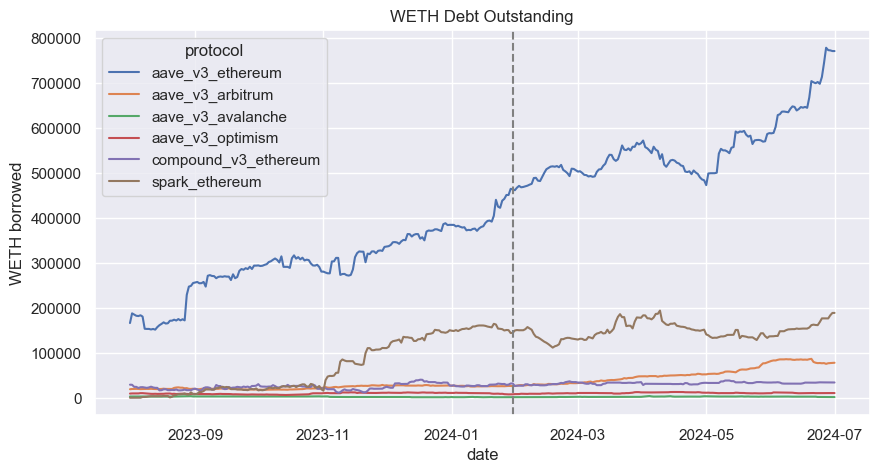

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=wETH_daily_short, x = 'date', y='variable debt', hue = 'protocol', ax = ax).set_title("WETH Debt Outstanding")
ax.set(ylabel = "WETH borrowed")
ax.axvline(pd.to_datetime("2024-01-30"), color="grey", linestyle="--", label="Merit Announcement")
#ax.axvline(pd.to_datetime("2024-03-19"), color="blue", linestyle="--", label="First distribution")
#ax.axvline(pd.to_datetime("2024-04-09"), color="blue", linestyle="--", label="Second distribution")
#ax.axvline(pd.to_datetime("2024-04-30"), color="blue", linestyle="--", label="Third distribution")

As shown in the figure above, Aave v3 Ethereum's WETH borrowed is much greater than the other protocols. The closest is Spark, which is unsurprising as it is a fork of Aave on the same chain. In the pre-treatment period (Nov 1, 2023 - Jan 29, 2024), Spark almost moves in parallel with Aave, except for the last two weeks of January. Given the volatility of crypto, we use the weekly average WETH borrowed in our estimations below instead of daily data. 

The correlation between Spark and Aave v3 Ethereum is 0.85.

          protocol  variable debt        date  after_announcement
278  aave_ethereum  281001.988052  2023-11-01               False
279  aave_ethereum  278988.138314  2023-11-02               False
280  aave_ethereum  277358.168726  2023-11-03               False
281  aave_ethereum  277253.669302  2023-11-04               False
282  aave_ethereum  303656.485159  2023-11-05               False


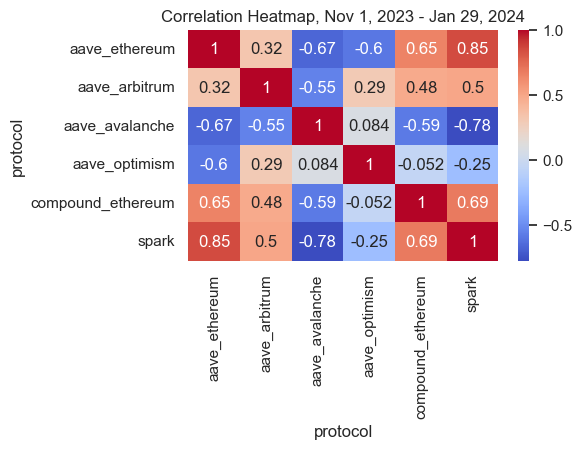

In [21]:
## Calculate Correlation Matrix

debt = wETH_daily_short[['protocol', 'variable debt', 'date']]
debt['after_announcement'] = pd.to_datetime(debt['date']) >= pd.to_datetime("2024-01-30")
debt = debt[(debt.date >=datetime(2023, 11, 1).date()) & (debt.date < datetime(2024, 9, 1).date())]

debt = debt.replace({'aave_v3_ethereum':'aave_ethereum', 'aave_v3_arbitrum':'aave_arbitrum', 'aave_v3_avalanche':'aave_avalanche', 'aave_v3_optimism':'aave_optimism','compound_v3_ethereum':'compound_ethereum', 'spark_ethereum':'spark'})

debt_before = (debt.query("~after_announcement") # filter pre-intervention period
            .pivot(index='protocol', columns="date")['variable debt'] # make one column per year and one row per state
            .T) # flip the table to have one column per protocol

correlation = debt_before[['aave_ethereum', 'aave_arbitrum', 'aave_avalanche', 'aave_optimism', 'compound_ethereum', 'spark']].corr()

plt.figure(figsize=(5, 3))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap, Nov 1, 2023 - Jan 29, 2024')
plt.show()

### Synthetic Difference-in-Differences <a class="anchor" id="synth"></a>

The gold standard for measuring causal impact is to conduct randomized experiments, also called A/B testing. When randomization is not possible or feasible, one can sometimes apply causal inference methods to measure the impact from observational data. The impact of interest here is the difference between the WETH borrowed on Aave Ethereum during Merit (Jan 30 to April 30) and the WETH that would have been borrowed on Aave Ethereum in the counterfactual world where Merit never occurred. However, the counterfactual world did not happen, so we cannot directly observe the impact. 

One way to overcome this problem is to use as controls similar lending protocols that did not go through incentive programs at the same time as Aave Ethereum. "Similar" means these control protocols, or a weighted combination of them, moved in sync with Aave Ethereum **before** Merit started. Then, under the assumption that Aave Ethereum would have continued the same pattern in the treatment period had Merit not happened, the average impact of Merit is the difference between the change in the controls and the change in Aave Ethereum before and after Merit started. 

The formal math of the synthetic diff-in-diff is as the following:
- pretreatment period: November 1, 2023 - Jan 29, 2024
- treatment period: Jan 30, 2024 - April 30, 2024

The average causal effect, $\tau^{sdid}$ is estimated by minimizing the mean squared error of the following weighted regression:
\begin{equation}
\Big(\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}, \hat{\beta} \Big) = \text{argmin}_{\tau^{sdid}, \mu, \alpha, \beta} \Big\{\sum_{i=1}^{N} \sum_{t=1}^{T}(Y_{it} - \mu - \alpha_i - \beta_t - W_{it}\tau)^2 \hat{\omega}_i^{sdid} \hat{\lambda}_t^{sdid}  \Big\}
\end{equation}

where $i$ represents a lending protocol, and $t$ indicates time in weeks. Given crypto's volatility, we use weekly average values for our estimations. The other variables are:
- $Y_{it} $: average WETH borrowed on protocol $i$ in week $t$
- $W_{it} \in \{0,1\} $: the binaary treatment indicator. $W_{it} = 1$ for Aave Ethereum during the treatment period, and $W_{it} = 0$ otherwise.
- $\mu$: regression intercept.
- $\alpha_i$: protocol $i$'s fixed effect
- $\beta_t$: time fixed effect
- $\hat{\omega}_i^{sdid}$: protocol $i$' weight. The protocol weights align the pre-treatment trends in the WETH borrowed of the control protocols with those in Aave Ethereum. E.g.$\sum_i^5 \hat{\omega}_i^{sdid}Y_{it} = Y_{t}^{\text{aave,eth}}$
- $\hat{\lambda}_t^{sdid}$: time weights that align pre-treatment time periods with post-treatment time periods (details below).


### $\hat{\omega}_i^{sdid}$ and $\hat{\lambda}_t^{sdid}$

**To estimate the impact $\hat{\tau}^{sdid}$, we first need to estimate the time and unit weights $\hat{\omega}_i^{sdid}$ and $\hat{\lambda}_t^{sdid}$. Next we will compute $\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}, \hat{\beta}$ via the weighted regression in equation (1)**


#### Estimate $\hat{\omega}_i^{sdid}$
The control protocols' unit weights are the solution to:

\begin{equation}
    (\hat{\omega}_0, \hat{\omega}^{sdid}) = \text{argmin} \sum^{T_\text{pre}}_{t=1} \Big(\omega_0 + \sum_{i=1}^{5}\omega_i Y_{it} - Y_t^{\text{aave,eth}}   \Big)^2 + \zeta^2 T_\text{pre}||\omega||^2_2 \tag{2}
\end{equation}

subject to constraints $\sum_{i=1}^5 \omega_i = 1$ and $\omega_i >= 0$, $\forall i$. 

The regularization paramter $\zeta$ is calculated as:

\begin{equation}
    \zeta = (N_{\text{tr}}T_{\text{post}})^{1/4} \hat{\sigma} \hspace{1cm}\text{ with } \hspace{1cm} \hat{\sigma}^2 = \frac{1}{N_{\text{co}}(T_{\text{pre}-1})}\sum_{i=1}^{N_{\text{co}}} \sum_{t=1}^{T_{\text{pre}-1}}(\Delta_{it} - \bar{\Delta})^2 \tag{3}
\end{equation}
where $\Delta = Y_{i(t+1)} - Y_{it}$ and $\bar{\Delta} = \frac{1}{N_{\text{co}}(T_{\text{pre}}-1)} \sum_{i=1}^{N_{\text{co}}} \sum_{t=1}^{T_{\text{pre}-1}}\Delta_{it} $. $N_{\text{co}} = 5$ is the number of control units, and $N_\text{tr} = 1$ is the number of treatment units, which is just Aave Ethereum. $T_{\text{post}}$ and $T_{\text{pre}}$ are the number of pre-treatment and post-treatment time periods, ie., the number of weeks before and after Jan 30, 2024, from Nov 1, 2023 to April 30, 2024.

The constraints that the weights of the control protocols are positive and sum to 1 ensure the solution is unique. The regularization parameter $\zeta$ is selected to match the average size of a one-period outcome change $\Delta_{it}$ for untreated units in the pre-treatment period. The scaling term $(N_{\text{tr}}T_{\text{post}})^{1/4}$ is motived by theory; please refer to the paper by [Athey et al, 2021](https://www.nber.org/system/files/working_papers/w25532/w25532.pdf) for more details. The regularization term is meant to distribute the weights among the control units more evenly.

The code below first calculates $\zeta$ from equation (3), then estimate the unit weights $\omega$ from equation (2).

In [22]:
## Compute Zeta

def calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    n_treated_post = data.query(post_col).query(treat_col).shape[0]
    
    first_diff_std = (data
                      .query(f"~{post_col}")
                      .query(f"~{treat_col}")
                      .sort_values(year_col)
                      .groupby(state_col)
                      [outcome_col]
                      .diff()
                      .std())
    
    return n_treated_post**(1/4) * first_diff_std

In [23]:
## function to fit unit weights

def fit_unit_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    zeta = calculate_regularization(data, outcome_col, year_col, state_col, treat_col, post_col)
    pre_data = data.query(f"~{post_col}")
    
    # pivot the data to the (T_pre, N_co) matrix representation
    y_pre_control = (pre_data
                     .query(f"~{treat_col}")
                     .pivot(index=year_col, columns=state_col, values=outcome_col))
    
    # group treated units by time periods to have a (T_pre, 1) vector.
    y_pre_treat_mean = (pre_data
                        .query(f"{treat_col}")
                        .groupby(year_col)
                        [outcome_col]
                        .mean())
    
    # add a (T_pre, 1) column to the begining of the (T_pre, N_co) matrix to serve as intercept
    T_pre = y_pre_control.shape[0]
    X = np.concatenate([np.ones((T_pre, 1)), y_pre_control.values], axis=1) 
    
    # estimate unit weights. Notice the L2 penalty using zeta
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(X@w - y_pre_treat_mean.values)  + T_pre*zeta**2 * cp.sum_squares(w[1:]))
    constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
    #+ T_pre*zeta**2 * cp.sum_squares(w[1:])
    
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=False)
    
    print("Intercept:", w.value[0])
    return pd.Series(w.value[1:], # remove intercept
                     name="unit_weights",
                     index=y_pre_control.columns)

##### Convert daily to weekly averages and estimate unit weights

In [32]:
debt['treated'] = np.where(debt['protocol'] == 'aave_ethereum', True, False)
debt_short = debt[(debt.date >=datetime(2023, 11, 1).date()) & (debt.date < datetime(2024, 5, 1).date())]
debt_short.tail(5)

data = debt_short.copy()
data['date'] = pd.to_datetime(data['date'])

data_weekly = data.groupby('protocol').resample("W", on="date").mean()
data_weekly.reset_index(inplace=True)
data_weekly['after_announcement'] = np.where(data_weekly['date'] >= datetime(2024, 1, 30), True, False)
data_weekly['treated'] = np.where(data_weekly['protocol']=='aave_ethereum', True, False)

unit_weights = fit_unit_weights(data_weekly,
                                outcome_col="variable debt",
                                year_col="date",
                                state_col="protocol",
                                treat_col="treated",
                                post_col="after_announcement")

unit_weights.round(3)

Intercept: 235033.93861851326


protocol
aave_arbitrum       -0.000
aave_avalanche      -0.000
aave_optimism       -0.000
compound_ethereum    0.051
spark                0.949
Name: unit_weights, dtype: float64

Because Aave Etheruem is a much larger protocol than even the closest competitor Spark, equation (2) resulted in a large intercept, $\omega_0 = 235,033$ WETH. The correlation plot above showed that the Aave deployments on Arbitrum, Avalanche, and Optimism are either negatively correlated or have low correlation with Aave Ethereum, so these control units received weights of 0. Negative weights are not allowed. Spark, which was most similar to Aave Ethereum both in term of level and trend, received a high weight of 0.95, followed by Compound with 0.05.

#### Estimate Time Weights $\hat{\lambda}_t^{\text{sdid}}$

We estimate the time weights by solving

\begin{equation}
    (\hat{\lambda_0}, \hat{\lambda^{\text{sdid}}}) = \text{argmin} \sum_{i=1}^{N_{\text{co}}} \Big (\lambda_0 + \sum_{t+1}^{T_{\text{pre}}} \lambda_t Y_{it} - \frac{1}{T_{\text{post}}}\sum_{t=T_{\text{pre}+1}}^{T}Y_{it}\Big)^2 \tag{4}
\end{equation}

where $\sum_{t+1}^{T_{\text{pre}}}\lambda_t = 1$, $\lambda>=0$, and $\lambda_t = \frac{1}{T_{\text{post}}}$ for $t = T_{\text{pre}}+1,...,T$.

The time weights serve a similar function as the unit weights. Instead of weighting all pre-periods periods equally, more weight is placed on weeks that are representative of the average outcome post-treatment.

In [133]:
def fit_time_weights(data, outcome_col, year_col, state_col, treat_col, post_col):
        
        control = data.query(f"~{treat_col}")
        
        # pivot the data to the (T_pre, N_co) matrix representation
        y_pre = (control
                 .query(f"~{post_col}")
                 .pivot(index=year_col, columns=state_col, values=outcome_col))
        
        # group post-treatment time period by units to have a (1, N_co) vector.
        y_post_mean = (control
                       .query(f"{post_col}")
                       .groupby(state_col)
                       [outcome_col]
                       .mean()
                       .values)
        
        # add a (1, N_co) vector of 1 to the top of the matrix, to serve as the intercept.
        X = np.concatenate([np.ones((1, y_pre.shape[1])), y_pre.values], axis=0)

        # estimate time weights
        w = cp.Variable(X.shape[0])
        objective = cp.Minimize(cp.sum_squares(w@X - y_post_mean))
        constraints = [w[1:] >= 0]
        #cp.sum(w[1:]) == 1,
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        # print("Intercept: ", w.value[0])
        return pd.Series(w.value[1:], # remove intercept
                         name="time_weights",
                         index=y_pre.index)

In [87]:

time_weights = fit_time_weights(data_weekly,
                                outcome_col="debt",
                                year_col="date",
                                state_col="protocol",
                                treat_col="treated",
                                post_col="after_announcement")

time_weights.round(3)

Intercept:  5018.403177896251


date
2023-11-05   -0.000
2023-11-12   -0.000
2023-11-19   -0.000
2023-11-26    0.141
2023-12-03   -0.000
2023-12-10   -0.000
2023-12-17   -0.000
2023-12-24   -0.000
2023-12-31   -0.000
2024-01-07    0.253
2024-01-14   -0.000
2024-01-21    0.000
2024-01-28    0.607
Name: time_weights, dtype: float64

Again, as the post-treatment WETH borrowed is much higher than the pre-treatment level, there is a large intercept, $\lambda_0 = 5018$. Only the weeks of 11/26/2023, 01/07/2024, and 01/28/2024 have positive weights

Text(0, 0.5, 'wETH Debt Outstanding')

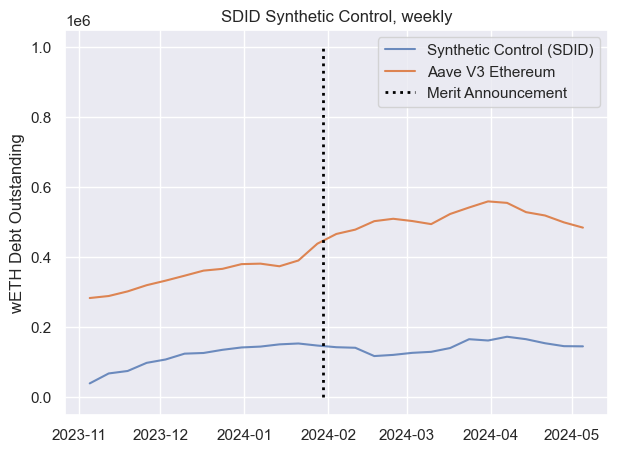

In [83]:
intercept = 235033.93861851326
data_piv = data_weekly.pivot(index="date", columns="protocol", values="debt")

sc_did = data_piv.drop(columns="aave_ethereum").values @ unit_weights.values

fig, (ax1) = plt.subplots(1, figsize=(7,5))
ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)", color="C0", alpha=.8)
ax1.plot(data_piv["aave_ethereum"], label="Aave V3 Ethereum", color="C1")
ax1.vlines(x=datetime(2024, 1, 30), ymin=0, ymax=1000000, linestyle=":", lw=2, label="Merit Announcement", color="black")

ax1.legend()
ax1.set_title("SDID Synthetic Control, weekly")
ax1.set_ylabel("wETH Debt Outstanding")

#### Estimate impact $\tau$

Recall that the causal impact $\tau$ is the solution to equation (1):

\begin{equation}
\Big(\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}, \hat{\beta} \Big) = \text{argmin}_{\tau^{sdid}, \mu, \alpha, \beta} \Big\{\sum_{i=1}^{N} \sum_{t=1}^{T}(Y_{it} - \mu - \alpha_i - \beta_t - W_{it}\tau)^2 \hat{\omega}_i^{sdid} \hat{\lambda}_t^{sdid}  \Big\}
\end{equation}

This is a weighted least squares regression, where the regression weights are the products of the time and unit weights. Recall that $W_{it}$ is an indicator that equals 1 when the protocol is Aave Ethereum and time is post-treatment. The code below combines the time and unit weights, and estimates $\hat{\tau}^{sdid}, \hat{\mu}, \hat{\alpha}$, and $\hat{\beta}$.

In [84]:
def join_weights(data, unit_w, time_w, year_col, state_col, treat_col, post_col):
    return (
        data
        .set_index([year_col, state_col])
        .join(time_w)
        .join(unit_w)
        .reset_index()
        .fillna({time_w.name: 1 / len(pd.unique(data.query(f"{post_col}")[year_col])),
                 unit_w.name: 1 / len(pd.unique(data.query(f"{treat_col}")[state_col]))})
        .assign(**{"weights": lambda d: (d[time_w.name] * d[unit_w.name]).round(10)})
        .astype({treat_col: int, post_col: int}))

In [127]:
sdid_data = join_weights(data_weekly, unit_weights, time_weights,
                        year_col="date",
                        state_col="protocol",
                        treat_col="treated",
                        post_col="after_announcement")

sdid_data.rename(columns={'variable debt':'debt'}, inplace=True)

sdid_data['weights'] = sdid_data['weights'].round(6)

sdid_model = smf.wls("debt ~ after_announcement*treated",
                    data=sdid_data,
                    weights=sdid_data["weights"]+1e-10).fit()

summary_table = sdid_model.summary().tables[1]

pd.options.display.float_format = '{:.1f}'.format

df_coef = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])
df_coef['coef'] = pd.to_numeric(df_coef['coef'])
df_coef



,,coef,std err,t,P>|t|,[0.025,0.975]
0,Intercept,140200.0,5332.879,26.285,0.000,1.3e+05,1.51e+05
1,after_announcement,5189.1,7541.820,0.688,0.492,-9706.661,2.01e+04
2,treated,267600.0,7541.830,35.489,0.000,2.53e+05,2.83e+05
3,after_announcement:treated,99280.0,1.07e+04,9.309,0.000,7.82e+04,1.2e+05


### Results <a class="anchor" id="result"></a>

#### Average Impact Estimation (ATT) <a class="anchor" id="estimate"></a>

The average impact of Merit on Aave Ethereum from Jan 30 to April 30, 2024 ($\tau$), also called the "average treatment effect on the treated (ATT)", is 99,280 WETH, or approx $238 million at 2,400 USD per WETH. The remaining coefficients are:
- $\mu = 140,200$
- $\beta_t = 5,189.1$
- $\alpha_{\text{aave eth}} = 267,600$

The ATT is graphically represented as the difference between the solid green line and dotted green line the figure below. The solid green line represents Aave Ethereum's counterfactual trajectory if Merit had not occurred. The dotted green line connects the (weighted) averages of the actual Aave Ethereum before and after Merit announcement.

Text(0.5, 0, 'Dates')

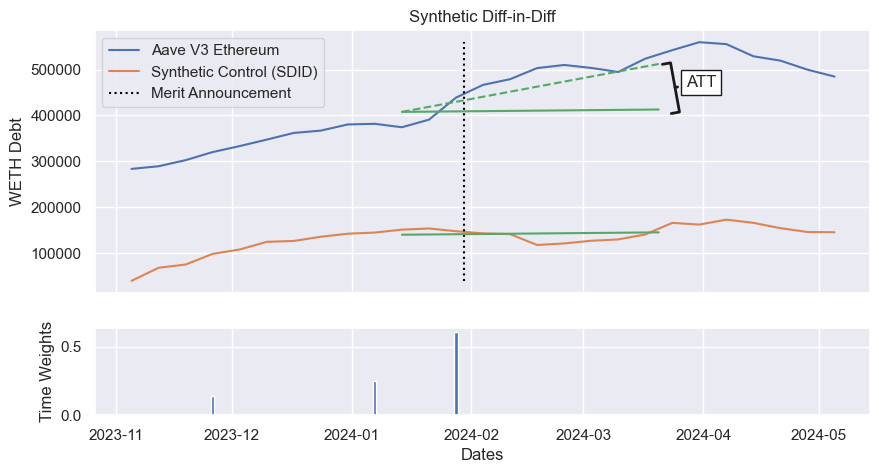

In [68]:

time_weights = time_weights.reset_index()
time_weights['date'] = pd.to_datetime(time_weights['date'])
time_weights['week'] = time_weights['date'].dt.isocalendar().week

avg_pre_period  = time_weights['date'][round((time_weights.index*time_weights['time_weights']).sum(),0)]
avg_post_period = data_weekly.query("date>='2024-01-30'")['date'].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data_piv.index, data_piv['aave_ethereum'], label="Aave V3 Ethereum")
ax1.plot(data_piv.index, sc_did, label="Synthetic Control (SDID)")
# ax1.vlines(1989, data_piv["california"].min(), sc_did.max(), color="black", ls="dotted", label="Prop. 99")
ax1.vlines(datetime(2024, 1, 30), sc_did.min(), data_piv['aave_ethereum'].max(), color="black", ls="dotted", label="Merit Announcement")

pre_sc = sdid_model.params["Intercept"]
post_sc = pre_sc + sdid_model.params["after_announcement"]
pre_treat = pre_sc + sdid_model.params["treated"]
post_treat = post_sc + sdid_model.params["treated"] + sdid_model.params["after_announcement:treated"]

sc_did_y0 = pre_treat + (post_sc - pre_sc)

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2", ls="dashed")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2")
ax1.annotate('ATT', xy=(avg_post_period + pd.Timedelta(weeks=0.5), pre_treat  + (post_treat-pre_treat)/2), xytext=(avg_post_period+ pd.Timedelta(weeks=1), pre_treat  + (post_treat-pre_treat)/2-5000 ), 
            fontsize=12, ha='left', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.5', lw=2.0, color='k'))

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.set_ylabel("WETH Debt")

ax2.bar(time_weights['date'], time_weights['time_weights'])
ax2.set_ylabel("Time Weights")
ax2.set_xlabel("Dates")

#### Inference <a class="anchor" id="inf"></a>

#### Placebo Variance Estimation

Unfortunately, the variance of the weighted regression above does not take into consideration the uncertainty of the weights. To calculate statistical significance and confidence intervals properly, we run the following placebo test. We randomly select a protocol from the control group, and pretend that it had the treatment even though it did not. We run the synthetic DID exercise for the randomly selected control unit, and compare its placebo ATT with the AAVE Ethereum ATT. We repeat this process many times. The variance of the placebo ATT is the placebo variance of the synthetic DiD.

Mathematically, the bootstrapped variance and confidence interval are:
$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$

In the following code, we combine all the functions for computing synthetic DID into a single function, and then run the random selection 200 times. 

In [131]:
def synthetic_diff_in_diff(data, outcome_col, year_col, state_col, treat_col, post_col):
    
    # find the unit weights
    unit_weights = fit_unit_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    
    print('found unit weights: ', unit_weights)

    # find the time weights
    time_weights = fit_time_weights(data,
                                    outcome_col=outcome_col,
                                    year_col=year_col,
                                    state_col=state_col,
                                    treat_col=treat_col,
                                    post_col=post_col)
    print('found time weights: ', time_weights)

    # join weights into DiD Data
    sdid_data = join_weights(data, unit_weights, time_weights,
                            year_col=year_col,
                            state_col=state_col,
                            treat_col=treat_col,
                            post_col=post_col)
    
    sdid_data["weights"] = np.where(sdid_data['weights'] < 0, 0, sdid_data['weights'])
    print('joined weights into DiD data: ')

    # run DiD
    formula = f"{outcome_col} ~ {post_col}*{treat_col}"
    sdid_model = smf.wls(formula, data=sdid_data, weights=sdid_data["weights"]+1e-10).fit()
    print('ran sDiD model: ')

    return sdid_model.params[f"{post_col}:{treat_col}"]


data_weekly.rename(columns={'variable debt':'debt'}, inplace=True)
aave_ethereum_ATT = synthetic_diff_in_diff(data_weekly, 
                       outcome_col="debt",
                       year_col="date",
                       state_col="protocol",
                       treat_col="treated",
                       post_col="after_announcement")
aave_ethereum_ATT 


Intercept: 235033.93861851326
found unit weights:  protocol
aave_arbitrum       -0.0
aave_avalanche      -0.0
aave_optimism       -0.0
compound_ethereum    0.1
spark                0.9
Name: unit_weights, dtype: float64
found time weights:  date
2023-11-05   -0.0
2023-11-12   -0.0
2023-11-19   -0.0
2023-11-26    0.1
2023-12-03   -0.0
2023-12-10   -0.0
2023-12-17   -0.0
2023-12-24   -0.0
2023-12-31   -0.0
2024-01-07    0.3
2024-01-14   -0.0
2024-01-21    0.0
2024-01-28    0.6
Name: time_weights, dtype: float64
joined weights into DiD data: 
ran sDiD model: 


99283.78310210949

In [140]:

def compute_se(bootstrap_rounds, data, outcome_col, year_col, state_col, treat_col, post_col):
    placebo_att = []
    controls = data.query("~treated")["protocol"].unique()
    print(controls)

    for i in range(bootstrap_rounds):
        protocol = np.random.choice(controls)
        print(protocol)
        placebo_data = data.assign(placebo_state = data["protocol"] == protocol)
        placebo_att.append(synthetic_diff_in_diff(placebo_data, 
                                               outcome_col=outcome_col,
                                               year_col=year_col,
                                               state_col=state_col,
                                               treat_col='placebo_state',
                                               post_col=post_col))
    return {'placebo se': np.std(placebo_att), 'placebo_att': placebo_att}


bootstrap_rounds = 200
se_sdid = compute_se(bootstrap_rounds, data_weekly, "debt", "date", "protocol", "treated", "after_announcement")


['aave_arbitrum' 'aave_avalanche' 'aave_optimism' 'compound_ethereum'
 'spark']
aave_avalanche
Intercept: -22056.180164547237
found unit weights:  protocol
aave_arbitrum       0.3
aave_ethereum       0.0
aave_optimism       0.3
compound_ethereum   0.3
spark               0.0
Name: unit_weights, dtype: float64
found time weights:  date
2023-11-05    0.4
2023-11-12   -0.0
2023-11-19   -0.0
2023-11-26    0.7
2023-12-03   -0.0
2023-12-10    0.5
2023-12-17   -0.0
2023-12-24   -0.0
2023-12-31   -0.0
2024-01-07   -0.0
2024-01-14   -0.0
2024-01-21   -0.0
2024-01-28   -0.0
Name: time_weights, dtype: float64
joined weights into DiD data: 
ran sDiD model: 
aave_optimism
Intercept: -9360.19366474845
found unit weights:  protocol
aave_arbitrum        0.3
aave_avalanche       0.3
aave_ethereum       -0.0
compound_ethereum    0.3
spark                0.0
Name: unit_weights, dtype: float64
found time weights:  date
2023-11-05   0.2
2023-11-12   0.3
2023-11-19   0.3
2023-11-26   0.3
2023-12-03   0.2
20

In [141]:
se_sdid['placebo se']

29895.005376705798

In [147]:
print(f"90% CI: ({aave_ethereum_ATT -1.65*se_sdid['placebo se']}, {aave_ethereum_ATT +1.65*se_sdid['placebo se']})")

90% CI: (49957.02423054493, 148610.54197367406)


The placebo standard error is 29,895 WETH. The estimated average impact of Merit is an increase of 99,283 WETH, with confidence interval (49,957, 148,610), which is statistically significant. 

We can also calculate the impact of Merit and confidence interval week by week, as implemented below.

In [97]:
### Calculate the effect date by date:

effects = {date: synthetic_diff_in_diff(data_weekly.query(f"~after_announcement|(date=='{date}')"), 
                                        outcome_col="debt",
                                        year_col="date",
                                        state_col="protocol",
                                        treat_col="treated",
                                        post_col="after_announcement")
           for date in data_weekly.query(f"after_announcement")["date"].unique()}

effects = pd.Series(effects)

Intercept: 225506.77962694675
found unit weights:  protocol
aave_arbitrum       -0.060138
aave_avalanche      -0.040116
aave_optimism       -0.240787
compound_ethereum    0.341138
spark                1.001051
Name: unit_weights, dtype: float64
Intercept:  -23.885522294933164
found time weights:  date
2023-11-05   -4.659007e-08
2023-11-12   -1.885272e-08
2023-11-19   -1.240620e-08
2023-11-26    8.850769e-02
2023-12-03   -1.776513e-09
2023-12-10   -4.051270e-09
2023-12-17   -8.205252e-09
2023-12-24   -5.688720e-09
2023-12-31   -2.867999e-09
2024-01-07    1.300403e-01
2024-01-14   -4.523253e-10
2024-01-21    2.432619e-10
2024-01-28    7.814521e-01
Name: time_weights, dtype: float64
joined weights into DiD data: 
ran sDiD model: 
Intercept: 225506.77962694675
found unit weights:  protocol
aave_arbitrum       -0.060138
aave_avalanche      -0.040116
aave_optimism       -0.240787
compound_ethereum    0.341138
spark                1.001051
Name: unit_weights, dtype: float64
Intercept:  875.34

In [98]:
effects

2024-02-04     45730.043193
2024-02-11     57698.057807
2024-02-18    157877.710469
2024-02-25    157005.248783
2024-03-03    147243.458610
2024-03-10    119125.520772
2024-03-17    111246.082953
2024-03-24    140539.960094
2024-03-31    160332.643721
2024-04-07    148799.534577
2024-04-14    127737.987248
2024-04-21    128971.120678
2024-04-28    119909.563425
2024-05-05     80063.447817
dtype: float64

In [100]:
# compute_se(bootstrap_rounds, data_weekly, "debt", "date", "protocol", "treated", "after_announcement")

standard_errors = {date: compute_se(bootstrap_rounds, data_weekly.query(f"~after_announcement | date=='{date}'"),
                                    outcome_col="debt",
                                    year_col="date",
                                    state_col="protocol",
                                    treat_col="placebo_state",
                                    post_col="after_announcement")
                   for date in data_weekly.query(f"after_announcement")["date"].unique()}    

['aave_arbitrum' 'aave_avalanche' 'aave_optimism' 'compound_ethereum'
 'spark']
compound_ethereum
Intercept: -17997.916515103923
found unit weights:  protocol
aave_arbitrum     0.284144
aave_avalanche    0.279679
aave_ethereum     0.068963
aave_optimism     0.295355
spark             0.071859
Name: unit_weights, dtype: float64
Intercept:  -1599.622000995968
found time weights:  date
2023-11-05    2.297477e-01
2023-11-12   -1.675777e-11
2023-11-19   -2.075875e-11
2023-11-26   -2.434685e-11
2023-12-03   -2.231705e-11
2023-12-10   -2.068819e-11
2023-12-17   -1.531132e-11
2023-12-24   -1.716482e-11
2023-12-31   -1.345442e-11
2024-01-07   -1.186830e-11
2024-01-14   -1.130689e-11
2024-01-21   -9.398862e-12
2024-01-28    9.182926e-01
Name: time_weights, dtype: float64
joined weights into DiD data: 
ran sDiD model: 
compound_ethereum
Intercept: -17997.916515103923
found unit weights:  protocol
aave_arbitrum     0.284144
aave_avalanche    0.279679
aave_ethereum     0.068963
aave_optimism     0.

In [102]:
data_piv['sc_did'] = sc_did
se_df = pd.DataFrame(standard_errors).T
se_df.reset_index(inplace=True)
se_df.rename(columns={'index':'date'}, inplace=True)

In [105]:
data_piv = data_piv.merge(se_df, how = "left", left_index=True, right_on='date')
inference_df = data_piv.query("date >= '2024-02-04'")
inference_df.set_index('date', inplace=True)
inference_df['effect'] = effects
inference_df['lower_CI'] = inference_df['effect'] - 1.65*inference_df['placebo se']
inference_df['upper_CI'] = inference_df['effect'] + 1.65*inference_df['placebo se']

(array([19754., 19768., 19783., 19797., 19814., 19828., 19844.]),
 [Text(19754.0, 0, '2024-02-01'),
  Text(19768.0, 0, '2024-02-15'),
  Text(19783.0, 0, '2024-03-01'),
  Text(19797.0, 0, '2024-03-15'),
  Text(19814.0, 0, '2024-04-01'),
  Text(19828.0, 0, '2024-04-15'),
  Text(19844.0, 0, '2024-05-01')])

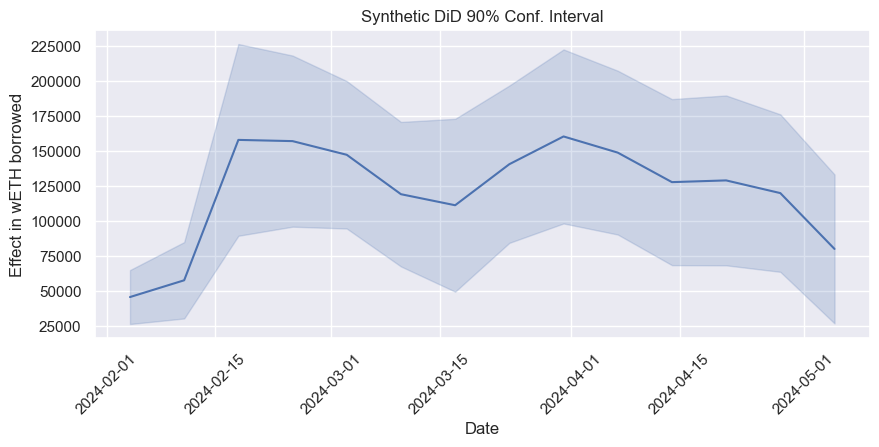

In [146]:
inference_df['effect'] = pd.to_numeric(inference_df['effect'], errors='coerce')
inference_df['lower_CI'] = pd.to_numeric(inference_df['lower_CI'], errors='coerce')
inference_df['upper_CI'] = pd.to_numeric(inference_df['upper_CI'], errors='coerce')

plt.figure(figsize=(10,4))

plt.plot(inference_df.index, inference_df['effect'], color="C0")
plt.fill_between(inference_df.index, inference_df['lower_CI'], inference_df['upper_CI'], alpha=0.2,  color="C0")

plt.ylabel("Effect in wETH borrowed")
plt.xlabel("Date")
plt.title("Synthetic DiD 90% Conf. Interval")
plt.xticks(rotation=45)

### Identifying Assumptions <a class="anchor" id="assume"></a>

1. Control groups are not affected by treatment
    Some of the lending protocols in the control group, especially Spark, are direct competitors to Aave. Users of Aave often use Spark as well, depending on which protocol offers higher return. Therefore, the assumption that the control group is not affected by Merit is violated. However, I argue that since the goal of the Merit program was to increase Aave's marketshare on Ethereum, attracting users from Spark is part of the intended effect. This situation is different from most causal studies where treatment and control groups are users from the **same** company, where violation of the assumption would lead to over- or -underestimation of the treatment's impact on the company as a whole. 

2. Control groups did not implement incentive programs of their own
    Aave announced the rules of the Merit program publically, so we cannot rule out the possibility of control protocols attempting to privately implement programs of their own in response. If the control protocols implemented programs that would have increased the WETH borrowed on their own platforms, then the estimated ATT of 99,283 WETH would be an underestimation.

    

## References <a class="anchor" id="ref"></a>

I would like to thank Matheus Facure for his Python code. His book [Causal Inference for the Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) has been a great resource for learning causal methods. 

Arkhangelsky, Dmitry, Susan Athey, David A Hirshberg, Guido W Imbens, and Stefan Wager. 2019. “Synthetic Difference in Differences.” National Bureau of Economic Research.